# Table of Contents
- [Introduction](#Introduction)
    - [Imports](#Imports)
- [Approach #1 - Binary Classification](#Approach-#1---Binary-Classification)
    - [Preprocessing](#Preprocessing-binary-data)
    - [Evaluating and comparing binary models](#Evaluating-and-comparing-binary-models)
- [Approach #2 - Multiclass Classification](#Approach-#2---Multiclass-Classification)
    - [Preprocessing](#Preprocessing-multiclass-data)
    - [Evaluating and comparing multiclass models](#Evaluating-and-comparing-multiclass-models)
- [Model Selection from Binary and Multiclass Models](#Model-Selection-from-Binary-and-Multiclass-Models)
- [Insights from the Binary Approach](#Insights-from-the-Binary-Approach)
    - [Visualizing feature importances and directionality](#Visualizing-feature-importances-and-directionality)
- [Take Home Messages](#Take-Home-Messages)
- [Future Work](#Future-Work)

# Introduction

The purpose of this project is to be able to analyze the risk of a patient being readmitted, once they have been in 
the hospital. Other notebooks in the repository have visualized some aspects of the dataset we are working with, as 
well as quantified some differences between patients who are readmitted, and those who are not.  

However, pairwise group comparisons are unable to capture the complexity inherent in a multi-dimensional dataset. 
As such, in this notebook I will run various predictive models to determine which performs best, and then from those
models, extract information such as feature importances and coefficients to understand the relationship of each of 
these variables to the risk of readmission.

The end result of this project is to be able to go to hospital administrators, and make recommendations about key
areas to focus on during patient care, in order to make reduce the likelihood of readmissions, which is both costly
for the hospital and detrimental to patient wellbeing.

## Imports

In [864]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from xgboost import XGBClassifier


In [865]:
def classification_model_fit(model, parameter_grid):
    """Function to simplify the model fitting process
    model: classification model of choice
    parameter_grid: grid of parameter values to pass to the pipeline
    """
    clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('clf', model)])
    clf_cv = GridSearchCV(clf_pipeline, parameter_grid, cv=3)
    fitted_model = clf_cv.fit(X_train, y_train)
    return(fitted_model)

# Approach #1 - Binary Classification

## Preprocessing binary data

In [868]:
binary_df = pd.read_csv('binary_diabetes.csv')

In [869]:
binary_df['discharge_disposition_id'] = binary_df['discharge_disposition_id'].astype('str')
binary_df['admission_source_id'] = binary_df['admission_source_id'].astype('str')
_ = binary_df.select_dtypes(include=['int64']).columns
for col in _:
    binary_df[col] = binary_df[col].astype(float) #Convert int to float to reduce warning outputs

In [870]:
y = binary_df['readmitted'] 
X = binary_df.drop('readmitted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = binary_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = binary_df.select_dtypes(include=['object']).drop(['readmitted'], axis=1).columns

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                              ('cat', categorical_transformer, categorical_features)])

## Model 1 - Logistic Regression

In [871]:
# Fitting the model
simple_logreg_params = {'clf__penalty':['l1','l2'], 'clf__C':np.linspace(0.5,1.5,5), 'clf__solver':['liblinear']}
simple_logreg = classification_model_fit(LogisticRegression(), simple_logreg_params)

In [872]:
#Extracting coefficients
simple_logreg_coef = simple_logreg.best_estimator_.named_steps['clf'].coef_
simple_logreg_coef = [i for i in simple_logreg_coef[0]]

## Model 2 - XGBClassifier

In [873]:
simple_xgb_params = {'clf__max_depth':[10, 20, 30, 40, 50], 'clf__objective':['binary:logistic']}
simple_xgb = classification_model_fit(XGBClassifier(), simple_xgb_params)

In [874]:
#Extracting feature importances
simple_xgb_importances = simple_xgb.best_estimator_.named_steps['clf'].feature_importances_

## Model 3 - Random Forest

In [855]:
simple_rf_params = {'clf__n_estimators': [200, 300, 400], 'clf__max_depth': [10, 20, 30, 40, 50], 
             'clf__max_features': ['auto', 'sqrt'], 'clf__class_weight':['balanced']}
simple_rf = classification_model_fit(RandomForestClassifier(), simple_rf_params)

In [856]:
#Extracting feature importances
simple_rf_importances = simple_rf.best_estimator_.named_steps['clf'].feature_importances_

## Evaluating and comparing binary models

In [875]:
def evaluate_classification_model(model):
    model_predictions = model.predict(X_test)
    model_accuracy = accuracy_score(model_predictions, y_test)
    
    model_report = classification_report(model_predictions, y_test)
    
    model_roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return model_accuracy, model_report, model_roc_score

As a reminder, in the context of this project, we are interested in being able to predict and identify members of a 
minority class (patients who get readmitted), and that the identification of this minority class is particularly 
important.

This matters because it affects the metric that we choose to look at most closely. For this project, **recall** is a much
better metric than precision or accuracy, as it specifically emphasizes the ability of a model to identify rare 
instances which are also vitally important. As such, it will be the primary metric that I use to compare the following
three models.

In [876]:
logreg_acc, logreg_classification, logreg_roc = evaluate_classification_model(simple_logreg)
print("The accuracy of the logistic regression classifier is {}".format(logreg_acc))
print("The classification report of the logistic regression classifier is\n {}".format(logreg_classification))
print("The ROC-AUC score of the logistic regression classifier is {}".format(logreg_roc))

simple_xgb_acc, simple_xgb_classification, simple_xgb_roc = evaluate_classification_model(simple_xgb)
print("The accuracy of the XGBoost classifier is {}".format(simple_xgb_acc))
print("The classification report of the XGBoost classifier is\n {}".format(simple_xgb_classification))
print("The ROC-AUC score of the XGBoost classifier is {}".format(simple_xgb_roc))

simple_rf_acc, simple_rf_classification, simple_rf_roc = evaluate_classification_model(simple_rf)
print("The accuracy of the Random Forest classifier is {}".format(simple_rf_acc))
print("The classification report of the Random Forest classifier is\n {}".format(simple_rf_classification))
print("The ROC-AUC score of the Random Forest classifier is {}".format(simple_rf_roc))

The accuracy of the logistic regression classifier is 0.6391482469512195
The classification report of the logistic regression classifier is
               precision    recall  f1-score   support

          NO       0.84      0.65      0.73     16019
         YES       0.35      0.60      0.44      4973

   micro avg       0.64      0.64      0.64     20992
   macro avg       0.59      0.62      0.59     20992
weighted avg       0.72      0.64      0.66     20992

The ROC-AUC score of the logistic regression classifier is 0.6677016632026403
The accuracy of the XGBoost classifier is 0.6539157774390244
The classification report of the XGBoost classifier is
               precision    recall  f1-score   support

          NO       0.80      0.67      0.73     14823
         YES       0.44      0.60      0.51      6169

   micro avg       0.65      0.65      0.65     20992
   macro avg       0.62      0.64      0.62     20992
weighted avg       0.70      0.65      0.67     20992

The ROC-AU

## Model Selection

In this case, I will go with XGBoost as the model of choice, as it has the best recall score for the positive class i.e. readmitted patients, as well as having the highest ROC. Logistic Regression has a similar recall score, but ultimately XGBoost has a better ROC-AUC score and accuracy, so it outperforms Logistic Regression on all counts.

# Approach #2 - Multiclass Classification

## Preprocessing multiclass data

In [772]:
multiclass_df = pd.read_csv('cleaned_diabetes.csv')

In [782]:
multiclass_df['discharge_disposition_id'] = multiclass_df['discharge_disposition_id'].astype('str')
multiclass_df['admission_source_id'] = multiclass_df['admission_source_id'].astype('str')
_ = multiclass_df.select_dtypes(include=['int64']).columns
for col in _:
    multiclass_df[col] = multiclass_df[col].astype(float) #Convert int to float to reduce warning outputs

In [826]:
y = multiclass_df['readmitted'] 
X = multiclass_df.drop('readmitted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = multiclass_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = multiclass_df.select_dtypes(include=['object']).drop(['readmitted'], axis=1).columns

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                              ('cat', categorical_transformer, categorical_features)])

## Model #1 - Logistic Regression

In [798]:
# Fitting the model
multi_logreg_params = {'clf__penalty':['l2'], 'clf__C':np.linspace(0.5,1.5,5), 
                       'clf__solver':['lbfgs'], 'clf__multi_class':['ovr'], 'clf__max_iter':[1000]}
multi_logreg = classification_model_fit(LogisticRegression(), multi_logreg_params)

In [799]:
#Extracting coefficients
multi_logreg_coef = multi_logreg.best_estimator_.named_steps['clf'].coef_
multi_logreg_coef = [i for i in multi_logreg_coef[0]]

## Model #2 - XGBoost Classifier

In [814]:
multi_xgb_params = {'clf__max_depth':[10, 20, 30, 40, 50], 'clf__objective':['multi:softprob']}
multi_xgb = classification_model_fit(XGBClassifier(), multi_xgb_params)

In [815]:
#Extracting feature importances
multi_xgb_importances = multi_xgb.best_estimator_.named_steps['clf'].feature_importances_

## Model #3 - Random Forest Classifier

In [818]:
multi_rf_params = {'clf__n_estimators': [200, 300, 400], 'clf__max_depth': [10, 20, 30, 40, 50], 
             'clf__max_features': ['auto', 'sqrt'], 'clf__class_weight':['balanced']}
multi_rf = classification_model_fit(RandomForestClassifier(), simple_rf_params)

In [819]:
#Extracting feature importances
multi_rf_importances = multi_rf.best_estimator_.named_steps['clf'].feature_importances_

## Evaluating and comparing multiclass models

In [830]:
def evaluate_multiclass_model(model):
    model_predictions = model.predict(X_test)
    model_accuracy = accuracy_score(model_predictions, y_test)
    
    model_report = classification_report(model_predictions, y_test)
    return model_accuracy, model_report

In [832]:
multi_logreg_acc, multi_logreg_classification = evaluate_multiclass_model(multi_logreg)
print("The accuracy of the logistic regression classifier is {}".format(multi_logreg_acc))
print("The classification report of the logistic regression classifier is\n {}".format(multi_logreg_classification))

multi_xgb_acc, multi_xgb_classification = evaluate_multiclass_model(multi_xgb)
print("The accuracy of the XGBoost classifier is {}".format(multi_xgb_acc))
print("The classification report of the XGBoost classifier is\n {}".format(multi_xgb_classification))

multi_rf_acc, multi_rf_classification = evaluate_multiclass_model(multi_rf)
print("The accuracy of the Random Forest classifier is {}".format(multi_rf_acc))
print("The classification report of the Random Forest classifier is\n {}".format(multi_rf_classification))

The accuracy of the logistic regression classifier is 0.6152591349739001
The classification report of the logistic regression classifier is
               precision    recall  f1-score   support

         <30       0.00      0.35      0.01        26
         >30       0.15      0.50      0.23      2027
          NO       0.94      0.63      0.75     19403

   micro avg       0.62      0.62      0.62     21456
   macro avg       0.37      0.49      0.33     21456
weighted avg       0.87      0.62      0.70     21456

The accuracy of the XGBoost classifier is 0.62248322147651
The classification report of the XGBoost classifier is
               precision    recall  f1-score   support

         <30       0.03      0.44      0.06       132
         >30       0.25      0.51      0.33      3276
          NO       0.90      0.65      0.75     18048

   micro avg       0.62      0.62      0.62     21456
   macro avg       0.39      0.53      0.38     21456
weighted avg       0.80      0.62    

# Model Selection from Binary and Multiclass Models

Compared to the binary models, the multiclass models definitely take a hit in performance; the recall scores are 
notably low across the board, possibly due to the minority classes being even smaller in size than the binary model. 

Although I could still compare the models on the basis of their recall score, it seems relatively pointless. 
After all, the goal of the model is to be as useful as possible in predicting patients with risk of readmission;
with recall scores at 0.5 or lower, these multiclass models are essentially missing most of the cases that we are 
interested in. 

Binary models seem more appropriate for applicability, and so we should be drawing most of our insights
about variables from the binary approach. As the XGBoost model performed best (based on recall) from the set of 
binary models, that is the one I will be using to gain insights into feature importances, aided by the coefficients
from the binary logistic regression model.

# Insights from the Binary Approach

## Visualizing feature importances and directionality

In [879]:
# Creating a dataset of feature importances and coefficients
onehotfeatures = simple_logreg.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(categorical_features)
feature_list = list(numeric_features.copy())

onehot_features = [str(i) for i in onehotfeatures]
for i in onehot_features:
    feature_list.append(i)

In [880]:
importances_df = pd.DataFrame({'Feature Name':feature_list, 'Coefficients':simple_logreg_coef, 
                               'Importances':simple_xgb_importances})

importances_df = importances_df.sort_values(by='Importances', ascending=False).reset_index(drop=True)
print(importances_df.head(10))

                                        Feature Name  Coefficients  \
0                                   number_inpatient      0.278875   
1                              admission_source_id_4     -0.262808   
2          medical_specialty_ObstetricsandGynecology     -0.653527   
3                              admission_source_id_2     -0.239022   
4                                 max_glu_serum_None      0.000000   
5                                   number_diagnoses      0.204049   
6                                   number_emergency      0.140792   
7                         glyburide-metformin_Steady      0.162646   
8                                 nateglinide_Steady      0.067499   
9  medical_specialty_Surgery-Cardiovascular/Thoracic     -0.757315   

   Importances  
0     0.041540  
1     0.015853  
2     0.012322  
3     0.011678  
4     0.011229  
5     0.010916  
6     0.010242  
7     0.009756  
8     0.009630  
9     0.009616  


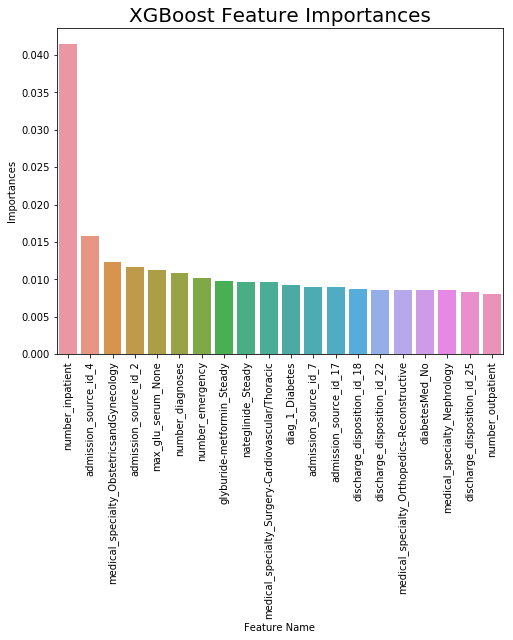

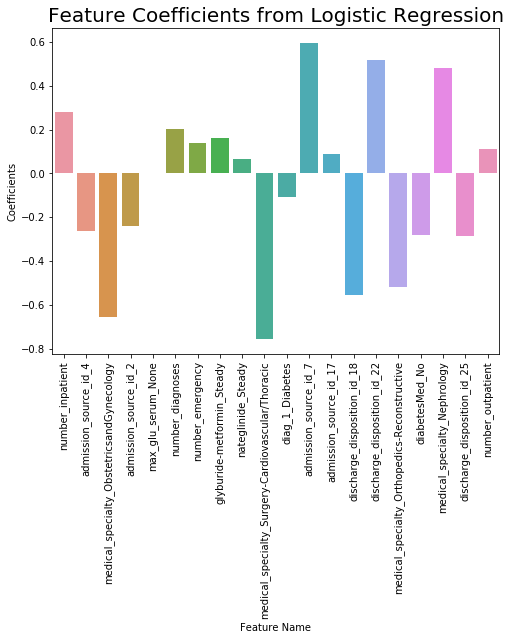

In [881]:
top_20_features = importances_df.head(20)

plt.figure(figsize=(8, 6))
sns.barplot(data=top_20_features, x='Feature Name', y='Importances')
plt.xticks(rotation=90)
plt.title("XGBoost Feature Importances", size=20)
plt.savefig('XGBoost Feature Importances.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(data=top_20_features, x='Feature Name', y='Coefficients')
plt.xticks(rotation=90)
plt.title("Feature Coefficients from Logistic Regression", size=20)
plt.savefig('Feature Coefficients from Logistic Regression.png', bbox_inches='tight')
plt.show()

# Take Home Messages

**The most important feature, and what it means**:
- What we can see from the best model is that there is one extremely important feature that predicts increased probability of readmission: the number of inpatient visits the patient has had in the past year. The positive coefficient also suggets that this variable is positively related to the risk of readmission i.e. the more inpatient visits, the greater the risk.

**Other important features**
- Other patient variables to keep track of are the number of emergency visits a patient had in the preceding year; the higher the number, the greater the risk of readmission. Patients with more diagnoses are also more likely to be readmitted.

- Patients with kidney issues (i.e. associated with the Nephrology department are also more likely to be readmitted, as are patients on glyburide-metform and nateglinide, both of which are antidiabetic medications. These two variables might be related: one of the consequences of diabetes is nephropathy, after all, so this signal we are getting from the model makes sense. Caveat: a primary diagnosis of diabetes is actually negatively associated with readmission risk, so this might be more complicated than simply assuming all diabetic patients are likely to be readmitted.

- There are two admission and discharge disposition variables that positively predict readmissions: 
    - Emergency/trauma patients appear to be more likely to be readmitted (see: IDs_mapping.csv in the repo)
    - Patients discharged to rehab units appear more likely to be readmitted (see: IDs_mapping.csv)

**Recommendations for hospital administration**
- If not already in place, I would suggest that a questionnaire be immediately administered to patients upon admission, where the number of emergency visits and inpatient visits in the past year can be recorded.
- As the patient progresses through the length of their stay, their patient profile can be updated with the relevant information e.g. the number of diagnoses they receive during their treatment, and the readmission risk correspondingly updated. 
- Reconsider discharging patients to rehab units, until a study can be conducted to understand why this appears to positively predict readmissions.

# Future Work

**Improving multiclass risk classification**
- It may be of interest to the hospital to quantify the risk of short-term readmissions versus long-term readmissions, as short-term readmissions i.e. <30 days, may signal the need for better treatment during a patient's stay. Currently, the models do not do a good job of predicting short-term readmissions, and I will need to adopt a different approach to improve their performance. 
- One possible approach could be SMOTE, where I oversample the minority class (here, patients readmitted in less than 30 days), which allows for them to be better represented in the dataset. 

Thank you for reading through this notebook, I hope it has been informative and helpful.